<a href="https://colab.research.google.com/github/Zhangxz010/Cours_Ensta_2025/blob/tp/travaux_diriges/tp5/TP_numero_cinq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurer votre colab pour le calcul sur GPU
Dans le menu au dessus, choisir le sous-menu **Exécution** puis l'option **Modifier le type d'exécution**.

Une fenêtre apparaît où vous pouvez choisir un accélérateur matériel. Choisissez un *GPU* puis *enregistrer* votre choix.

Afin de vérifier que vous avez bien configuré votre session pour utiliser un GPU, exécuter le code ci-dessous (en passant la souris, une petite flèche pour l'exécuter apparaît).

Si tout se passe bien, un tableau (en ascii) apparaît avec le type de carte (et son architecture) auquel vous avez accès. Si un message d'erreur apparaît, vérifiez dans **Modifier le type d'exécution** que l'accélérateur matériel est bien configuré pour un *GPU*

In [1]:
!nvidia-smi

Tue Mar  4 09:15:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Installation de PyCuda

Pour utiliser le GPU sous Python il faut soit installer **PyCuda** pour effectuer des calculs, soit **PyTorch** pour effectuer du machine learning accéléré par les GPUs.

Dans ce TP, nous nous bornerons uniquement à effectuer des calculs sur GPU !

Pour cela, il faut d'abord installer pyCuda et donc exécuter le code ci-dessous (toujours en appuyant sur la flèche pour exécuter le code, et attendez, cela prend un petit moment...)

In [2]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.3 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1-cp311-cp311-linux_x86_64.whl size=660393 sha256=2cc36843de98f673887d6d8b00041dd701e737b0fa7bf7f2330921e208bbe1e7
  Stored in directory: /root/.cache/pip/wheels/77/7e/6c/d2d1451ea6424cdc3d67b36c16fa7111eafdf2034bc3405666
Successfully built pycuda


# Vérification du bon fonctionnement du module PyCuda

Afin de vérifier le bon fonctionnement de l'installation, nous allons écrire un script Cuda qui servira en même temps d'exemple pour le TP d'aujourd'hui. Ce script sera scindé en plusieurs morceaux et commenté pour que vous compreniez chaque partie du code.

Ce code sera très simple : on va créer une matrice 4x4 avec des données prises "au hasard" (mais avec une graine aléatoire fixée, donc...) , recopier ce tableau dans la mémoire de la carte graphique et demander à la carte graphique de doubler la valeur de chaque élément de la matrice puis de recopier dans la mémoire de l'ordinateur les valeurs calculées. On affiche ensuite la matrice initiale et la matrice transformée.

Dans un premier temps, chargeons les modules python nécessaire à l'exécution d'un noyau Cuda (**Remarque** : l'importation de ces modules n'est nécessaire qu'une seule fois pour **TOUTE** la session. Il sera donc inutile de reimporter ces modules dans le reste du TD !) :

In [3]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

Créons à l'aide de numpy un tableau *a* dont les valeurs aléatoires sont issues d'une graine fixée :

In [4]:
import numpy
numpy.random.seed(1729)
a = numpy.random.randn(4,4) # Sous forme de matrice 4 x 4

Puisque certaines cartes graphiques supportent mal le double précision, nous allons demander à Python que les éléments de *a* soient en simple précision :

In [5]:
a = a.astype(numpy.float32)
print(a.nbytes)

64


Nous allons ensuite allouer de la place mémoire sur la mémoire vive du GPU. Comme en C, la place mémoire est exprimée en *Octets* :

In [6]:
a_gpu = cuda.mem_alloc(a.nbytes)

Une fois la réservation sur le GPU de faite, on recopie les valeurs de *a* dans le tableau *a_gpu* que l'on vient de réserver (htod signifie host **to** device):

In [7]:
cuda.memcpy_htod(a_gpu, a)

Il faut ensuite écrire le noyau qui s'exécutera sur la carte graphique à l'aide du langage CUDA (qui est une extension du langage C).

**Remarquez** dans le code qu'on s'assure que les indices donnés par les numéros de threads ne dépassent pas la dimension de la matrice !

In [13]:
mod = SourceModule("""
    __global__ void doublify(int dim_x, int dim_y, float *a) {
        int x = threadIdx.x;
        int y = threadIdx.y;

        if (x < dim_x && y < dim_y) {
            int idx = x + y * dim_x;
            a[idx] *= 2;
        }
    }
""")

Nous allons récupérer ensuite un "handle" sur le noyau cuda que l'on vient de créer (en invoquant le nom de la fonction) et l'invoquer sur la carte graphique en dimensionnant la grille de calcul à l'aide de *block=(4,4,1)* (et en l'adaptant aux dimensions de la matrice).

Ici, nous n'avons pas besoin de configurer de grilles car la dimension de la matrice *a* est petite, mais comme la taille d'un bloc dans une direction est limitée à 256, pour des cas plus gros, il faudra également passer une grille en paramètre à l'aide de *grid=(x,y,z)* où *x,y* et *z* sont des valeurs entières positives et utiliser dans le noyau cuda les valeurs *x,y* et *z* de **blockIdx** et **blockDim**.

**REMARQUE IMPORTANTE** : Le noyau cuda ne veut que des types C basiques en argument. Or un entier python est tout sauf un type basique du C. Donc pour passer un argument entier à un noyau cuda, il faut créer un entier 32 bits à l'aide de numpy.int32

In [14]:
func = mod.get_function("doublify")
dim = numpy.int32(4)
func(dim, dim, a_gpu, block=(4,4,1))

Il ne reste plus qu'à récupérer les nouvelles valeurs de la matrice en transférant les données de la matrice contenue par le GPU dans un tableau numpy se trouvant dans la RAM de l'ordinateur (dtoh signifie device **to** host) :

In [15]:
a_doubled = numpy.empty_like(a)
cuda.memcpy_dtoh(a_doubled, a_gpu)

Il ne reste plus qu'à afficher la matrice initiale puis la matrice obtenue par le calcul sur GPU :

In [16]:
print(f"a : {a}")
print(f"a_gpu : {a_doubled}")

a : [[-0.6873394  -0.82099473  1.6523609  -0.57529306]
 [ 1.0989678   0.92594606 -0.9934138  -0.8582211 ]
 [ 0.07488676  0.5293555   0.12095155 -0.22442362]
 [-1.5566785   0.05594088  0.16147153 -2.1346416 ]]
a_gpu : [[-2.7493577  -3.283979    6.6094437  -2.3011723 ]
 [ 4.395871    3.7037842  -3.9736552  -3.4328845 ]
 [ 0.29954705  2.117422    0.4838062  -0.89769447]
 [-6.226714    0.22376351  0.6458861  -8.538567  ]]


## Exercices de mises en bouche

En vous inspirant du programme commenté ci-dessus, écrivez un code avec un noyau Cuda qui fait la somme de deux vecteurs de réels simples précisions et qui range le résultat dans un troisième vecteur.

On s'exercera à utiliser des vecteurs de "grandes" dimensions (> 256) afin de s'entrainer à calculer des indices globaux dans le noyau cuda à l'aide de *threadIdx.x*, *blockIdx.x* et *dimBlock.x*.

Ecrivez (ou copier coller) votre code dans la cellule ci-dessous

In [17]:
# CUDA 核函数
mod = SourceModule("""
    __global__ void vector_add(float *a, float *b, float *c, int N) {
        int idx = threadIdx.x + blockIdx.x * blockDim.x;
        if (idx < N) {
            c[idx] = a[idx] + b[idx];
        }
    }
""")

# 生成随机向量
N = 1000000  # 1百万个元素
a = np.random.rand(N).astype(np.float32)
b = np.random.rand(N).astype(np.float32)

# 在 GPU 上分配内存
a_gpu = cuda.mem_alloc(a.nbytes)
b_gpu = cuda.mem_alloc(b.nbytes)
c_gpu = cuda.mem_alloc(a.nbytes)

# 复制数据到 GPU
cuda.memcpy_htod(a_gpu, a)
cuda.memcpy_htod(b_gpu, b)

# 获取 CUDA 核函数
vector_add = mod.get_function("vector_add")

# 计算线程块和网格大小
block_size = 256
grid_size = (N + block_size - 1) // block_size

# 调用 CUDA 核函数
vector_add(a_gpu, b_gpu, c_gpu, np.int32(N), block=(block_size, 1, 1), grid=(grid_size, 1, 1))

# 复制结果回 CPU
c = np.empty_like(a)
cuda.memcpy_dtoh(c, c_gpu)

# 结果验证
assert np.allclose(c, a + b)
print("向量加法成功！")


向量加法成功！


Une fois le code mis au point, recopiez le ci-dessous et adaptez le pour additionner deux matrices carrées dans une troisième.

In [19]:
mod = SourceModule("""
    __global__ void matrix_add(float *A, float *B, float *C, int N) {
        int i = threadIdx.x + blockIdx.x * blockDim.x;
        int j = threadIdx.y + blockIdx.y * blockDim.y;
        int index = i + j * N;

        if (i < N && j < N) {
            C[index] = A[index] + B[index];
        }
    }
""")

# 矩阵大小
N = 512  # 512x512 的矩阵
A = np.random.rand(N, N).astype(np.float32)
B = np.random.rand(N, N).astype(np.float32)

# 申请 GPU 内存
A_gpu = cuda.mem_alloc(A.nbytes)
B_gpu = cuda.mem_alloc(B.nbytes)
C_gpu = cuda.mem_alloc(A.nbytes)

# 复制数据到 GPU
cuda.memcpy_htod(A_gpu, A)
cuda.memcpy_htod(B_gpu, B)

# 获取 CUDA 核函数
matrix_add = mod.get_function("matrix_add")

# 计算线程块和网格大小
block_size = (16, 16, 1)
grid_size = (N // 16, N // 16, 1)

# 调用 CUDA 核函数
matrix_add(A_gpu, B_gpu, C_gpu, np.int32(N), block=block_size, grid=grid_size)

# 复制结果回 CPU
C = np.empty_like(A)
cuda.memcpy_dtoh(C, C_gpu)

# 结果验证
assert np.allclose(C, A + B)
print("矩阵加法成功！")


矩阵加法成功！


# Exercice final

Nous allons de nouveau nous intéresser à l'ensemble de Mandelbrot. La cellule ci-dessous contient un code permettant de calculer à l'aide de numpy un ensemble de mandelbrot (le code est simplifié par rapport aux codes sur CPU pour faciliter le TP même si il utilise la notation vectorielle de numpy (il faudra y faire attention pour code le noyau cuda !) : code repris de https://stackoverflow.com/questions/60467316/displaying-mandelbrot-set-in-python-using-matplotlib-pyplot-and-numpy).

Transformez le de sorte que sur GPU, chaque thread calcule un pixel de l'image de destination.

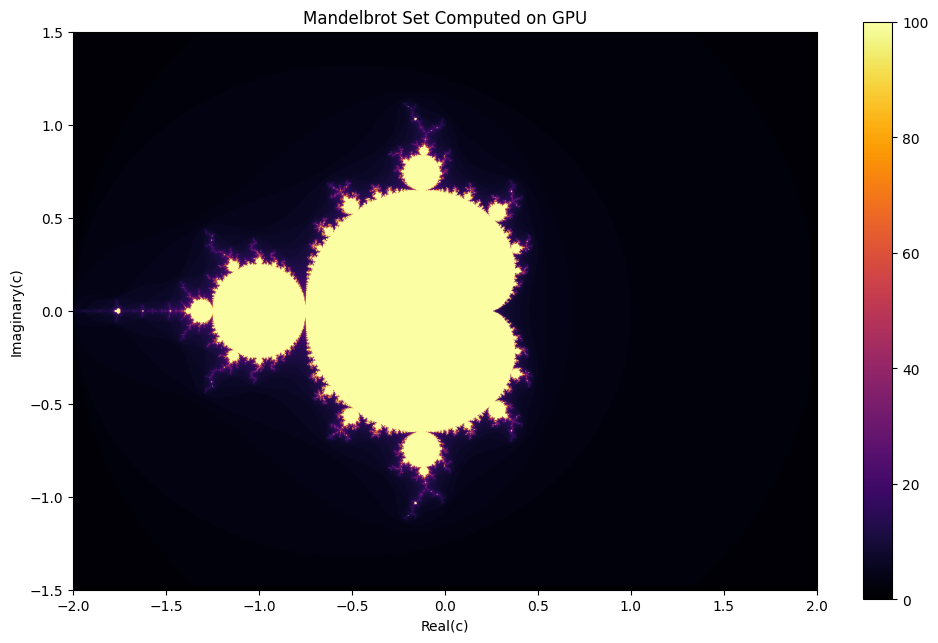

In [21]:
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt

# 1. Définition des paramètres
width, height = 1000, 1000  # Taille de l'image
max_iter = 100  # Nombre maximum d'itérations

# 2. Génération des coordonnées complexes
real = np.linspace(-2, 2, width).astype(np.float32)
imag = np.linspace(-1.5, 1.5, height).astype(np.float32)

# 3. Allocation mémoire GPU
output = np.zeros((height, width), dtype=np.int32)
output_gpu = cuda.mem_alloc(output.nbytes)

real_gpu = cuda.mem_alloc(real.nbytes)
imag_gpu = cuda.mem_alloc(imag.nbytes)

cuda.memcpy_htod(real_gpu, real)
cuda.memcpy_htod(imag_gpu, imag)

# 4. Compilation du noyau CUDA
mod = SourceModule("""
    __global__ void mandelbrot(float *real, float *imag, int *output, int max_iter, int width, int height) {
        int x = blockIdx.x * blockDim.x + threadIdx.x;
        int y = blockIdx.y * blockDim.y + threadIdx.y;

        if (x >= width || y >= height) return;

        int index = y * width + x;

        float cr = real[x];
        float ci = imag[y];

        float zr = 0.0, zi = 0.0;
        int iter = 0;

        while (zr*zr + zi*zi <= 4.0 && iter < max_iter) {
            float temp = zr * zr - zi * zi + cr;
            zi = 2.0 * zr * zi + ci;
            zr = temp;
            iter++;
        }
        output[index] = iter;
    }
""")

# Récupération de la fonction CUDA
mandelbrot = mod.get_function("mandelbrot")

# Définition de la grille et des blocs
block_size = (16, 16, 1)
grid_size = (width // 16, height // 16, 1)

# Exécution du noyau CUDA
mandelbrot(real_gpu, imag_gpu, output_gpu, np.int32(max_iter), np.int32(width), np.int32(height),
           block=block_size, grid=grid_size)

# Récupération des résultats
cuda.memcpy_dtoh(output, output_gpu)

# Affichage des résultats
plt.figure(figsize=(12, 7.5))
plt.imshow(output, extent=[-2, 2, -1.5, 1.5], cmap="inferno")
plt.xlabel("Real(c)")
plt.ylabel("Imaginary(c)")
plt.colorbar()
plt.title("Mandelbrot Set Computed on GPU")
plt.savefig("mandelbrot_gpu.png")
plt.show()
